In [61]:
import spectraltree
import time
import numpy as np
import matplotlib.pyplot as plt
import toytree
import toyplot
import toyplot.pdf
import toyplot.svg
import networkx as nx 
import pylab
from Bio import Phylo
import time 

In [233]:
def compute_similarity_matrix_from_tree_slow(T,mu):
    # compute similarity matrix, doesn't work with birth death

    # convert to networkx structure through external file
    T.write(path="output.tre", schema="newick")
    tree = Phylo.read("output.tre", "newick")
    net = Phylo.to_networkx(tree)

    # get leaves idx and names
    l_list = list(net.nodes())
    A = nx.adjacency_matrix(net)
    nz_idx = A.nonzero()    
    leave_idx = []
    for i in range(A.shape[0]):
        if np.sum(nz_idx[0]==i)==1:
            leave_idx.append(i)
    m = len(leave_idx)
    leave_idx = np.array(leave_idx)
    # compute shortest path distance between all leaves

    s_time = time.time()
    D = np.zeros((m,m))
    for i,T_i in enumerate(leave_idx):
        for j,T_j in enumerate(leave_idx):
            D[i,j] = nx.shortest_path_length(net,l_list[leave_idx[i]],l_list[leave_idx[j]],weight = "weight")            
    f_time = time.time()
    print('time shortest path is ', f_time-s_time)

    s_time = time.time()
    D_hat = nx.shortest_path_length(net,weight = "weight")
    print(D_hat)
    f_time = time.time()
    print('time shortest path is ', f_time-s_time)
    
    mu = (1-(1-mu)*4/3)**3
    S = mu**D
    return S

    

In [240]:
def compute_similarity_matrix_from_tree(T,mu):
    # compute similarity matrix, doesn't work with birth death

    # convert to networkx structure through external file
    T.write(path="output.tre", schema="newick")
    tree = Phylo.read("output.tre", "newick")
    net = Phylo.to_networkx(tree)

    # get leaves idx and names
    node_list = list(net.nodes())
    A = nx.adjacency_matrix(net)
    
    nz_idx = A.nonzero()    
    leave_idx = []
    l_list = []
    for i in range(A.shape[0]):
        if np.sum(nz_idx[0]==i)==1:
            leave_idx.append(i)
            l_list.append(node_list[i])
    m = len(leave_idx)
    leave_idx = np.array(leave_idx)
    
    # compute shortest path distance between all nodes in the tree
    D_all_tree = nx.shortest_path_length(net,weight = "weight")

    # extract only the distances between leaves
    D_hat = np.zeros((m,m))
    for node in D_all_tree:        
        # get source name        
        source_node = node[0]
        if source_node in l_list:   
            # get rel index
            s_idx = l_list.index(source_node)
            for k, v in node[1].items():
                if k in l_list:
                    t_idx = l_list.index(k)
                    D_hat[s_idx,t_idx]=v
                    
    # convert distance to similarity matrix
    mu = (1-(1-mu)*4/3)**3
    S = mu**D_hat
    return S


In [246]:
num_taxa = 50    # Number of terminal nodes
n = 10000        # Number of independent samples (sequence length)   
jc = spectraltree.Jukes_Cantor()   #set evolution process to the Jukes Cantor model
mutation_const = 0.9
mutation_rate = jc.p2t(mutation_const)        #set mutation rate between adjacent nodes to 1-0.9=0.1


# create a tree 
reference_tree = spectraltree.unrooted_pure_kingman_tree(num_taxa)
#reference_tree = spectraltree.unrooted_birth_death_tree(num_taxa)
#reference_tree = spectraltree.balanced_binary(num_taxa)
observations, taxa_meta = spectraltree.simulate_sequences(n, tree_model=reference_tree, seq_model=jc, mutation_rate=mutation_rate, alphabet="DNA")
S = spectraltree.JC_similarity_matrix(observations)
w_s,v_s = np.linalg.eigh(np.diag(np.sum(S,axis=1)) - S)
D_til = np.diag(np.sum(S,axis=1)**-0.5)
#w_n,v_n = np.lina

average difference between matrices: 0.0004891262086979113


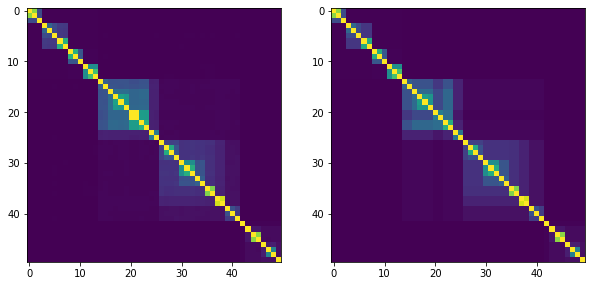

In [247]:
S_hat = compute_similarity_matrix_from_tree(reference_tree,mutation_const)
fig,ax = plt.subplots(1,2,figsize = (10,5))
ax[0].imshow(S)
ax[1].imshow(S_hat)
print('average difference between matrices:', (np.linalg.norm(S_hat-S)/num_taxa)**2)